<a href="https://colab.research.google.com/github/AnishPawar/Image_Captioning/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

import string
import glob
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

import numpy as np
from numpy import array
from tensorflow.keras.preprocessing import image
from time import time
from datetime import datetime
from tensorflow.keras.applications.inception_v3 import preprocess_input
!pip install tqdm
from tqdm import tqdm
import pickle
from pickle import dump, load
import os
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.layers import Add as add
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import keras.backend as k
from tensorflow.keras.preprocessing import sequence
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline



TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 15.7 MB 56 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
lucid 0.3.10 requires numpy<=1.19, but you have numpy 1.21.4 which is incompatible.
yellowbrick 1.3.post1 requires numpy<1.20,>=

In [ ]:
pip install -U numpy==1.18.5

     |████████████████████████████████| 20.1 MB 7.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
kapre 0.3.6 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Preprocessing Part 1

In [ ]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

filename = "/content/drive/MyDrive/Image_Captioning_DLFL/dataset/Flickr8k.token.txt"
doc = load_doc(filename)
print(doc[:100])


1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
# Each line in the Captions file represents one caption. It contains two columns separated by a Tab.
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


Before cleaning there are capital letter, single letters

In [ ]:
#print(list(descriptions.keys())[:5])
print(descriptions['1001773457_577c3a7d70'])

['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']


In [ ]:
# Cleaned by removing single letters, numbers and punctuations, and lowercasing all words.
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

After cleaning, single letters are removed and all are in lower case

In [ ]:
print(descriptions['1001773457_577c3a7d70'])

['black dog and spotted dog are fighting', 'black dog and tricolored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other']


In [ ]:
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [ ]:
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0] 
		dataset.append(identifier)
	return set(dataset)

filename = '/content/drive/MyDrive/Image_Captioning_DLFL/dataset/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
images = '/content/drive/MyDrive/Image_Captioning_DLFL/dataset/Flicker8k_Dataset/'
img = glob.glob(images + '*.jpg')
len(img)

8091

In [ ]:
# Loading Training files
train_images_file = '/content/drive/MyDrive/Image_Captioning_DLFL/dataset/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
        
train_img = []

for i in img: 
    if i[len(images):] in train_images: 
        train_img.append(i)
print("training images= ",len(train_img))

training images=  6000


train_img contains path of only training images

In [ ]:
# Loading Test Files
test_images_file = '/content/drive/MyDrive/Image_Captioning_DLFL/dataset/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for i in img: 
    if i[len(images):] in test_images: 
        test_img.append(i) 
print("testing images= ",len(test_img))

testing images=  1000


test_img contains path of only test images len(test_img) = 1000

In [ ]:
# Captions are enclosed with ‘startseq’ and ‘endseq’ for convenience
def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
# Inception V3 model was used to help with transfer learning
model = InceptionV3(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
# A new model was created by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# All the input images are first converted to size 299x299 for the inception model
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
# Given to inception model to encode the image to vector of size (2048,)
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) 
    return fea_vec

## You Only Run Once

In [ ]:
# from datetime import datetime
# from time import time
# # Call the funtion to encode all the train images
# # This will take a while on CPU - Execute this only once (takes approx 45 min)


# start = time()
# encoding_train = {}
# for img in tqdm(train_img):
#     encoding_train[img[len(images):]] = encode(img)
# print("Time taken in seconds =", time()-start)


In [ ]:
# # Save the bottleneck test features to disk, import pickle

# with open("/content/drive/My Drive/Colab Notebooks/pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)


In [ ]:
# # Call the funtion to encode all the test images - Execute this only once


# start = time()
# encoding_test = {}
# for img in tqdm(test_img):
#     encoding_test[img[len(images):]] = encode(img)
# print("Time taken in seconds =", time()-start)

In [ ]:
# # Save the bottleneck test features to disk


# with open("/content/drive/My Drive/Colab Notebooks/pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

## Data Preprocessing Part 2

In [ ]:
train_features = load(open("/content/drive/MyDrive/Image_Captioning_DLFL/pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# list of training captions called ‘vocab’ with words appearing at least 10 times in the corpus is created
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [ ]:
# Two dictionaries, one for word to indices (wordtoix) and one for indices to words (ixtoword)
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
with open('/content/drive/MyDrive/Image_Captioning_DLFL/testing/vocab.pkl', 'wb') as f:
        pickle.dump(vocab, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Image_Captioning_DLFL/testing/ixtoword.pkl', 'wb') as f:
        pickle.dump(ixtoword, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Image_Captioning_DLFL/testing/wordtoix.pkl', 'wb') as f:
        pickle.dump(wordtoix, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
vocab_size = len(ixtoword) + 1 
vocab_size

1652

In [ ]:
# ‘max_length’ was determined by the length of the longest caption in the training corpus
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
# !unzip '/content/drive/MyDrive/Image_Captioning_DLFL/glovedir/archive.zip' -d '/content/drive/MyDrive/Image_Captioning_DLFL/glovedir/'

In [ ]:
# GloVe (Global Vectors for word representation) corpus was used to get the embeddings of all the words in ‘vocab’. 
glove_dir = '/content/drive/MyDrive/Image_Captioning_DLFL/glovedir/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
#Get a 200-dim dense vector for each of the 10000 words in our vocabulary.
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))
start = time()
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Time taken in seconds =", time()-start)

Time taken in seconds = 0.005959987640380859


In [ ]:
embedding_matrix.shape

(1652, 200)

## Model Definition

In [ ]:
%tensorflow_version 1.x
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                        Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.layers import Add as add


inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=([inputs1, inputs2]), outputs=outputs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Training 

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
history = History()

In [ ]:
# The batch was generated with help of data_generator function, it creates multiple sequence pairs and pads them to max length
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = list(), list(), list()
                n=0

### Training Phase 1 

In [ ]:
# Initial Hyperparameters
epochs = 30
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
  generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[tensorboard_callback] )
  model.save('/content/drive/MyDrive/Image_Captioning_DLFL/model_weights/model_' + str(i) + '.h5')


2000/2000 [==============================] - 227s 114ms/step - loss: 2.4534


In [ ]:
model.save('/content/drive/MyDrive/Image_Captioning_DLFL/model_weights/model_epoch30.h5')

### Training Phase 2

In [ ]:
# %tensorflow_version 1.x    
# import tensorflow

# model = tensorflow.keras.models.load_model("/content/drive/MyDrive/Image_Captioning_DLFL/models/model_epoch30.h5")

In [ ]:
# For the second iteration, the following hyperparameters were adjusted: 
k.set_value(model.optimizer.lr,0.0001)
epochs = 100
number_pics_per_bath = 12
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    print(i)
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=2,callbacks=[tensorboard_callback])
    model.save('/content/drive/MyDrive/Image_Captioning_DLFL/model_weights_2/model_' + str(i) + '.h5')

0
500/500 - 60s - loss: 2.4784
1
500/500 - 59s - loss: 2.4223
2
500/500 - 59s - loss: 2.3985
3
500/500 - 60s - loss: 2.3860
4
500/500 - 60s - loss: 2.3759
5
500/500 - 59s - loss: 2.3646
6
500/500 - 59s - loss: 2.3555
7
500/500 - 59s - loss: 2.3501
8
500/500 - 59s - loss: 2.3428
9
500/500 - 59s - loss: 2.3379
10
500/500 - 60s - loss: 2.3347
11
500/500 - 60s - loss: 2.3298
12
500/500 - 60s - loss: 2.3269
13
500/500 - 59s - loss: 2.3212
14
500/500 - 59s - loss: 2.3139
15
500/500 - 60s - loss: 2.3120
16
500/500 - 60s - loss: 2.3072
17
500/500 - 59s - loss: 2.3040
18
500/500 - 59s - loss: 2.2990
19
500/500 - 60s - loss: 2.2974
20
500/500 - 60s - loss: 2.2960
21
500/500 - 60s - loss: 2.2894
22
500/500 - 60s - loss: 2.2881
23
500/500 - 60s - loss: 2.2837
24
500/500 - 59s - loss: 2.2831
25
500/500 - 59s - loss: 2.2795
26
500/500 - 60s - loss: 2.2758
27
500/500 - 59s - loss: 2.2734
28
500/500 - 60s - loss: 2.2696
29
500/500 - 60s - loss: 2.2678
30
500/500 - 60s - loss: 2.2661
31
500/500 - 60s -

In [ ]:
model.save('/content/drive/MyDrive/Image_Captioning_DLFL/model_weights_2/caption_model_100.h5') 

In [ ]:
model = load_model('/content/drive/MyDrive/Image_Captioning_DLFL/model_weights_2/caption_model_100.h5')                

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Testing 

In [ ]:
images = '/content/drive/MyDrive/Image_Captioning_DLFL/dataset/Flicker8k_Dataset/'

In [ ]:
with open("/content/drive/MyDrive/Image_Captioning_DLFL/pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
print([wordtoix['startseq']])

[1]


In [ ]:
def beam_search_predictions(photo, index = 3):
    start = [wordtoix['startseq']]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([photo, np.array(par_caps)])
            word_preds = np.argsort(preds[0])[-index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        print(start_word)
        start_word = start_word[-index:]
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
# pic = list(encoding_test.keys())[21]
# image = encoding_test[pic].reshape((1,2048))
# beam_search_predictions(image,index=1)

In [ ]:
# pic = list(encoding_test.keys())[21]
# image = encoding_test[pic].reshape((1,2048))
# beam_search_predictions(image,index=4)

In [ ]:
def print_predicitions_above_threshold(list1):
    threshold=0.8 
    x = np.array(list1) 
    print(np.unique(x)) 

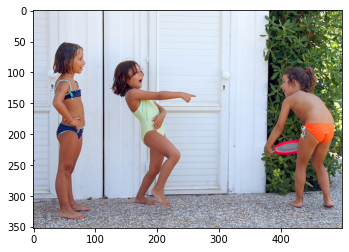

2689001252_e0016c89f0
['girl in pink bathing suit is jumping into the water'
 'two girls in swimsuits are playing in fountain']
0.5467707026923339
0.3655552228545123
0.3655552228545123
0.3655552228545123

Final Cumulative BLEU score: 0.41085909281396765





/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


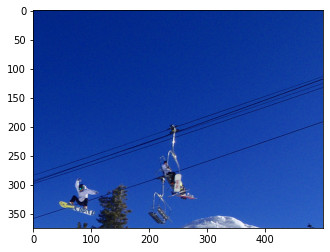

3200120942_59cfbb3437
['man in red pants is airborne on his snowboard'
 'skier is airborne in front of some trees']
0.7598356856515925
0.6240195441936915
0.6240195441936915
0.6240195441936915

Final Cumulative BLEU score: 0.6579735795581668





/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


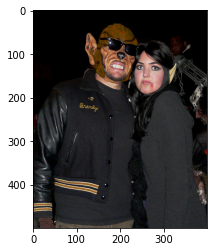

3047264346_e24601bfbf
['man in black leather and sunglasses is standing next to woman in black hat'
 'two men are standing in front of an sign'
 'two men in hats are standing in front of the sun']
0.5067309892897293
0.7765453555044466
0.7765453555044466
0.6799308458396492

Final Cumulative BLEU score: 0.6849381365345678





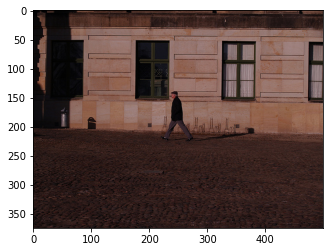

2196107384_361d73a170
['man is rollerblading down cement wall']
0.5623413251903491
0.5623413251903491
0.5623413251903491
0.5623413251903491

Final Cumulative BLEU score: 0.5623413251903491





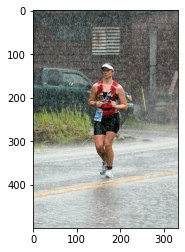

2698666984_13e17236ae
['man in red shirt jogs in race'
 'two children are playing soccer on the beach'
 'two men in camouflage pants stand in the middle of city street'
 'woman in red and white striped shirt is walking down the street']
0.5946035575013605
0.4538407873007614
0.605543865104477
0.41722614486115056

Final Cumulative BLEU score: 0.5178035886919373





/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


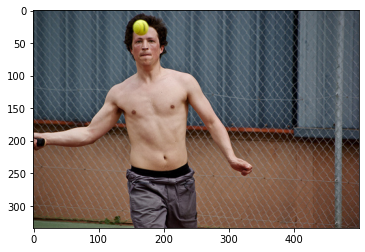

2883099128_0b056eed9e
['young boy singing skateboard trick on the pavement']
0
0
0
0

Final Cumulative BLEU score: 0.0





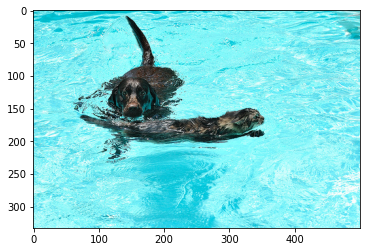

2599444370_9e40103027
['black dog splashes in the water'
 'three black dogs swimming in the water'
 'three dogs are swimming in the water']
0.4347208719449914
0.5169731539571706
0.6042750794713536
0.5169731539571706

Final Cumulative BLEU score: 0.5182355648326715





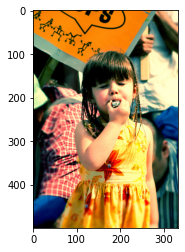

540721368_12ac732c6c
['woman in pink shirt is looking at something in crowd of people'
 'woman in pink shirt is looking at the camera while another girl watches'
 'woman in pink shirt is standing in front of group of staring people'
 'young girl with curly hair and green eyes']
0.38827267775222324
0.5942647088781684
0.5369787816169341
0.5721248424548514

Final Cumulative BLEU score: 0.5229102526755443





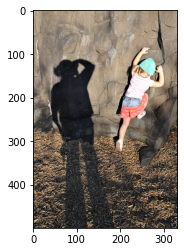

2208067635_39a03834ca
['boy in red shirt is playing with fallen leaves'
 'two boys are playing with ducks'
 'two boys are playing with ducks in the grass'
 'two people are standing in the middle of field']
0
0.5773502691896257
0.5773502691896257
0.5773502691896257

Final Cumulative BLEU score: 0.4330127018922193





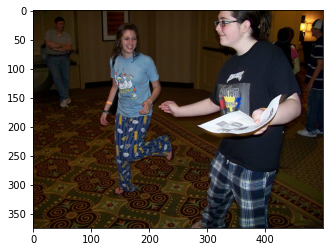

3477715432_79d82487bb
['woman in black and white striped shirt and headphones is standing next to man in white shirt and headphones'
 'woman in black and white striped shirt holding violin'
 'woman in black and white striped shirt is writing on cellphone']
0.7226568811456053
0.6773709971213142
0.6773709971213142
0.6799308458396492

Final Cumulative BLEU score: 0.6893324303069707





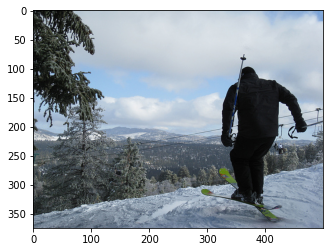

3139876823_859c7d7c23
['man in black cap snowboarding down mountain'
 'person in red jacket and black pants stands on snowy mountain'
 'person in red jacket snowboarding down mountain'
 'the man is climbing up snowy mountain']
0.5873949094699213
0.8210967436686386
0.8091067115702212
0.9193227152249185

Final Cumulative BLEU score: 0.7842302699834249





In [ ]:
list2=[41,424,922, 337, 161, 248,104, 96, 844,351,304,689,179,898]

for k in range(19,30):
  z=k
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048)) 
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  des=os.path.splitext(pic)[0]
  #print (z)
  print(des)
  #print(descriptions[des])
  predictions=[]
  start=time()
  predictions.append(beam_search_predictions(image,index=1))
  predictions.append(beam_search_predictions(image,index=2))
  predictions.append(beam_search_predictions(image,index=3))
  predictions.append(beam_search_predictions(image,index=4))
  print_predicitions_above_threshold(predictions)

    #calculation of BLEU scores
  candidate=[]
  reference=[]
  score=0

  for i in range(4):
    candidate.append(predictions[i])

  for i in range(5):
    reference.append(descriptions[des][i].split())

  for i in range(4):
    temp=sentence_bleu(reference,candidate[i].split(),smoothing_function=SmoothingFunction().method0)
    print(temp)
    score+=temp
  print('\nFinal Cumulative BLEU score: '+ str(score/4)+'\n\n\n')
